In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
alldata = pd.read_csv("/Users/zionmicwu/Desktop/Melbourne_housing_FULL.csv")

In [4]:
# Dataset Overview
print("Dataset Structure:")
print(alldata.info())

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  

In [5]:
# List all the columns with missing values
missing_data = alldata.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

missing_percentage = (missing_data / len(alldata)) * 100

missing_data_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

missing_data_df

,Missing Values,Percentage
BuildingArea,21115,60.576068
YearBuilt,19306,55.386293
Landsize,11810,33.881286
Car,8728,25.039447
Bathroom,8226,23.599277
Bedroom2,8217,23.573457
Lattitude,7976,22.882061
Longtitude,7976,22.882061
Price,7610,21.832057
CouncilArea,3,0.008607


In [6]:
# Check duplicate rows
duplicate_rows = alldata.duplicated().sum()
print(f"Number of duplicate rows in train dataset: {duplicate_rows}")
if duplicate_rows > 0:
    alldata = alldata.drop_duplicates()
    print("Duplicate rows removed from train dataset.")

Number of duplicate rows in train dataset: 1
Duplicate rows removed from train dataset.


In [7]:
# Keep only rows with complete data (no missing values)
houses = alldata.dropna()

# Select relevant columns
selected_columns = ["Rooms", "Price", "Distance", "Bedroom2", "Bathroom", "Car", "Landsize", "BuildingArea", "YearBuilt"]
workdata = houses[selected_columns]

In [8]:
# Data Overview
print("Dataset Shape:", workdata.shape)
print("\nData Types:\n", workdata.dtypes)

Dataset Shape: (8887, 9)

Data Types:
 Rooms             int64
Price           float64
Distance        float64
Bedroom2        float64
Bathroom        float64
Car             float64
Landsize        float64
BuildingArea    float64
YearBuilt       float64
dtype: object


In [9]:
workdata.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt
count,8887.000000,8.887000e+03,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
mean,3.098909,1.092902e+06,11.199887,3.078204,1.646450,1.692247,523.480365,149.309477,1965.753348
std,0.963786,6.793819e+05,6.813402,0.966269,0.721611,0.975464,1061.324228,87.925580,37.040876
min,1.000000,1.310000e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000
25%,2.000000,6.410000e+05,6.400000,2.000000,1.000000,1.000000,212.000000,100.000000,1945.000000
50%,3.000000,9.000000e+05,10.200000,3.000000,2.000000,2.000000,478.000000,132.000000,1970.000000
75%,4.000000,1.345000e+06,13.900000,4.000000,2.000000,2.000000,652.000000,180.000000,2000.000000
max,12.000000,9.000000e+06,47.400000,12.000000,9.000000,10.000000,42800.000000,3112.000000,2019.000000


In [10]:
# Summary Statistics
summary_stats = workdata.describe().T
skewness = workdata.skew()
kurtosis = workdata.kurtosis()

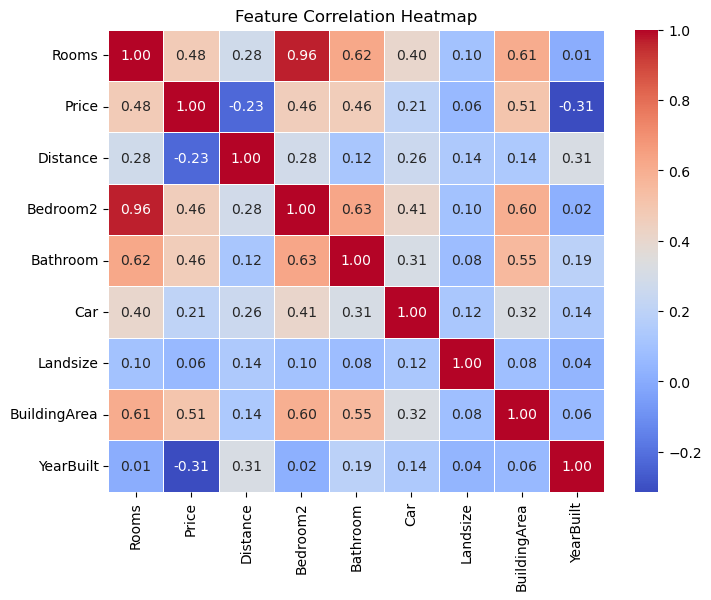

In [11]:
# Correlation Matrix & Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(workdata.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
# Analyse the potential outliers
outlier_dict = {}
for col in workdata.columns:
    Q1 = workdata[col].quantile(0.25)
    Q3 = workdata[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = workdata[(workdata[col] < lower_bound) | (workdata[col] > upper_bound)][col]

    # Store results
    outlier_dict[col] = {
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outlier Count": len(outliers),
        "Outlier Percentage": (len(outliers) / len(workdata)) * 100,
    }

# Convert results to a DataFrame for better visualization
outlier_df = pd.DataFrame.from_dict(outlier_dict, orient="index")
print(outlier_df)

outlier_cols = outlier_df[outlier_df["Outlier Percentage"] > 0].index

              Lower Bound  Upper Bound  Outlier Count  Outlier Percentage
Rooms               -1.00         7.00              6            0.067514
Price          -415000.00   2401000.00            420            4.726004
Distance            -4.85        25.15            406            4.568471
Bedroom2            -1.00         7.00              7            0.078767
Bathroom            -0.50         3.50            129            1.451558
Car                 -0.50         3.50            479            5.389895
Landsize          -448.00      1312.00            209            2.351750
BuildingArea       -20.00       300.00            417            4.692247
YearBuilt         1862.50      2082.50             10            0.112524


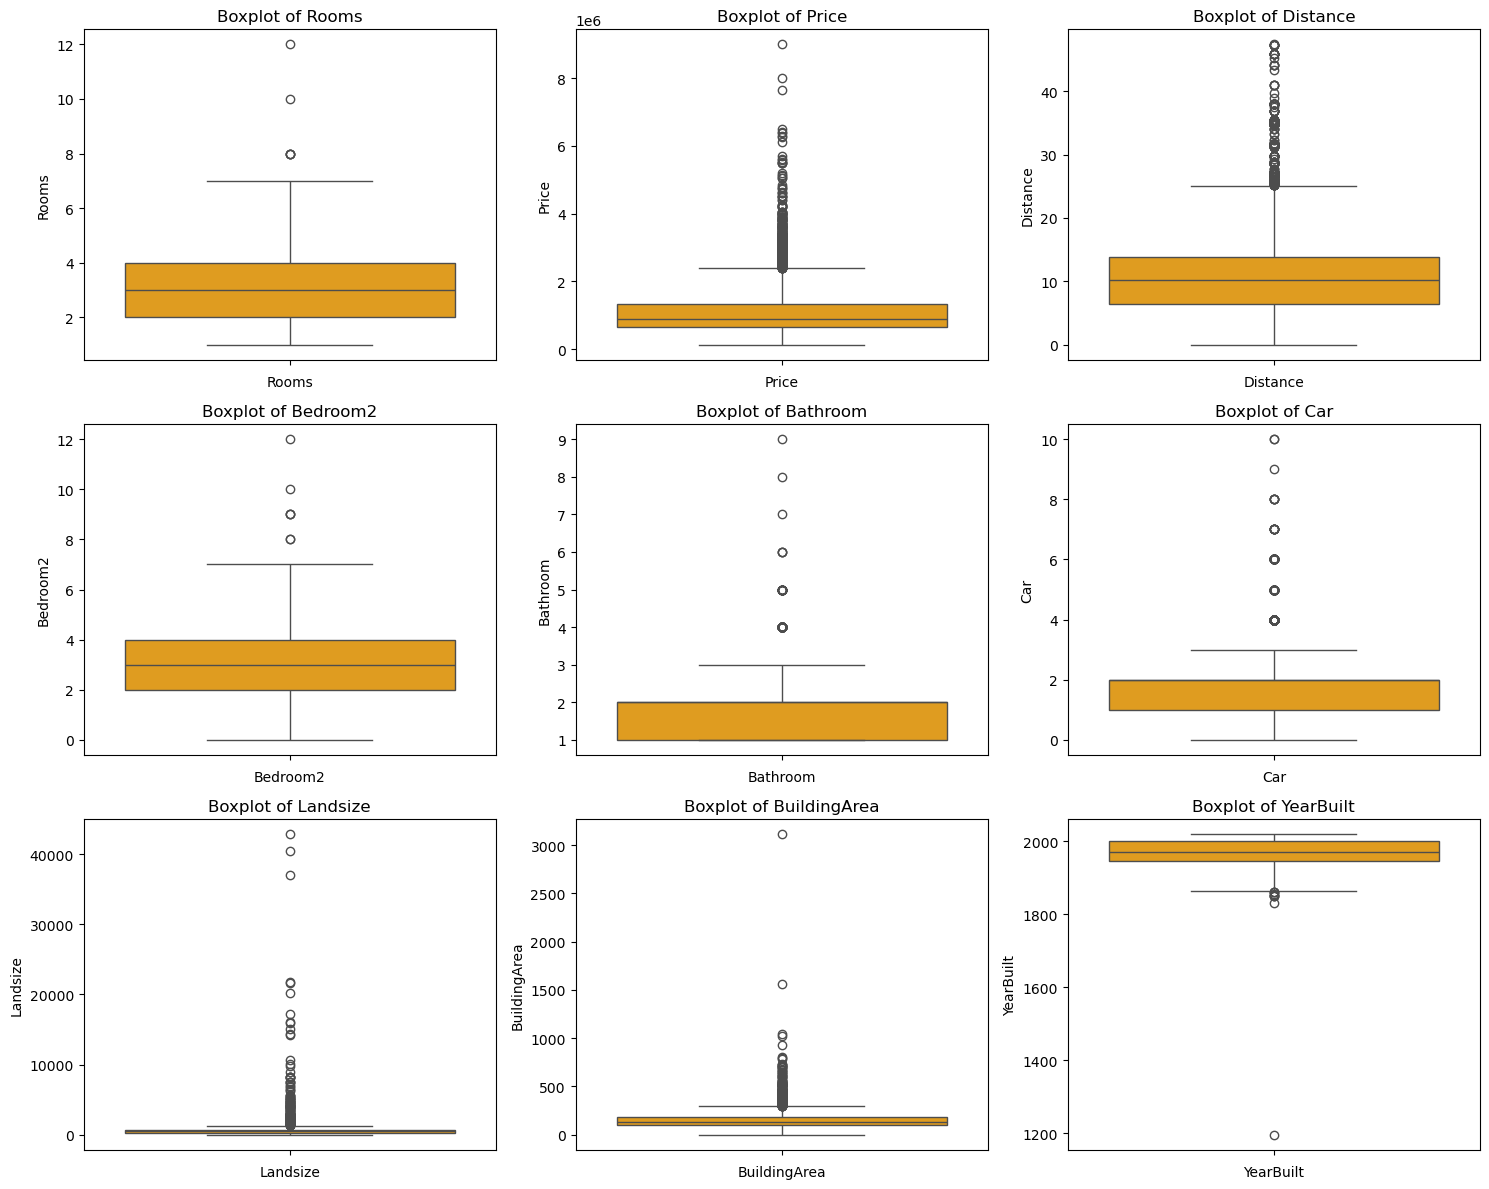

In [13]:
# Plot the boxplots for each columns' outliers
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, col in enumerate(outlier_cols):
    row, col_idx = divmod(i, 3)  # Compute row and column indices
    sns.boxplot(y=workdata[col].dropna(), ax=axes[row, col_idx], color='orange')
    axes[row, col_idx].set_title(f"Boxplot of {col}")
    axes[row, col_idx].set_xlabel(col)
plt.tight_layout()
plt.show()

In [14]:
# Handling unreasonable outliers
workdata = workdata[
    (workdata["Rooms"] > 0) & 
    (workdata["Bedroom2"] > 0) & 
    (workdata["Bathroom"] > 0) & 
    (workdata["Car"] >= 0) & 
    (workdata["Landsize"] > 0) & 
    (workdata["BuildingArea"] > 0) & 
    (workdata["BuildingArea"] <= 1500)&
    (workdata["YearBuilt"] <= 2016) &
    (workdata["YearBuilt"] >= 1800)
]

houses = houses[
    (houses["Rooms"] > 0) & 
    (houses["Bedroom2"] > 0) & 
    (houses["Bathroom"] > 0) & 
    (houses["Car"] >= 0) & 
    (houses["Landsize"] > 0) & 
    (houses["BuildingArea"] > 0) & 
    (houses["BuildingArea"] <= 1500)&
    (houses["YearBuilt"] <= 2016) &
    (houses["YearBuilt"] >= 1800)
]

In [15]:
print(workdata.shape)
print(houses.shape)

(7771, 9)
(7771, 21)


In [16]:
# Feature Transformation - Log Transformation on Price, Landsize, BuildingArea, Distance
workdata['Log_Price'] = np.log1p(workdata['Price'])
workdata['Log_Landsize'] = np.log1p(workdata['Landsize'])
workdata['Log_BuildingArea'] = np.log1p(workdata['BuildingArea'])
workdata['Log_Distance'] = np.log1p(workdata['Distance'])

In [17]:
# Standardizing the features (Z-score normalization)
workdata.drop(columns=["Price","Landsize","Distance","BuildingArea"], inplace = True)
scaler = StandardScaler()
data_cols = workdata.columns.tolist()
workdata[data_cols] = scaler.fit_transform(workdata[data_cols])

In [18]:
# Save the cleaned dataset
workdata.to_csv("Melbourne_housing_preprocessed.csv", index=False)

In [19]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(workdata)
    inertia.append(kmeans.inertia_)

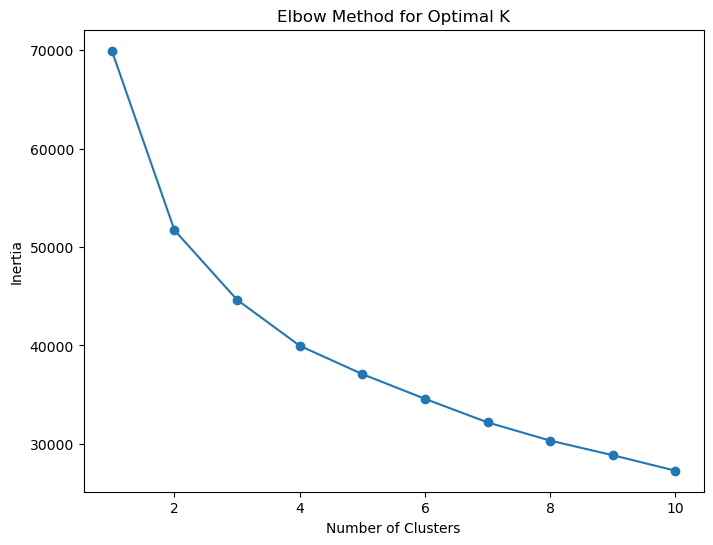

In [20]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [21]:
# Perform K-Means clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=4, random_state=42, n_init=10)
workdata["KMeans_Cluster"] = kmeans_optimal.fit_predict(workdata)

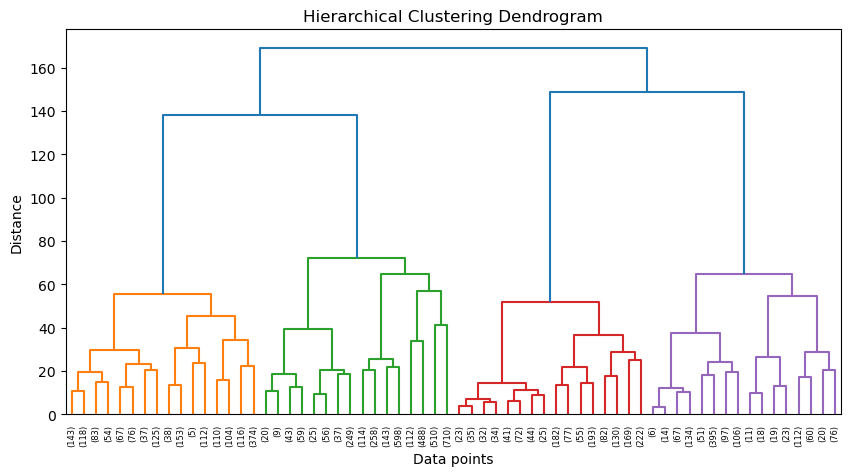

In [22]:
# Perform Hierarchical Clustering and plot the dendrogram
linked = linkage(workdata, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()

In [23]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 4

agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
workdata["Agg_Cluster"] = agg_cluster.fit_predict(workdata)

# Count the number of each category
print(workdata["Agg_Cluster"].value_counts())

Agg_Cluster
0    3431
3    1715
2    1416
1    1209
Name: count, dtype: int64


In [24]:
kmeans_score = silhouette_score(workdata, workdata["KMeans_Cluster"])
print(f"Silhouette Score for kmeans Clustering (K=4): {kmeans_score:.4f}")

agg_score = silhouette_score(workdata, workdata["Agg_Cluster"])
print(f"Silhouette Score for Agglomerative Clustering (K=4): {agg_score:.4f}")

Silhouette Score for kmeans Clustering (K=4): 0.3319
Silhouette Score for Agglomerative Clustering (K=4): 0.3374


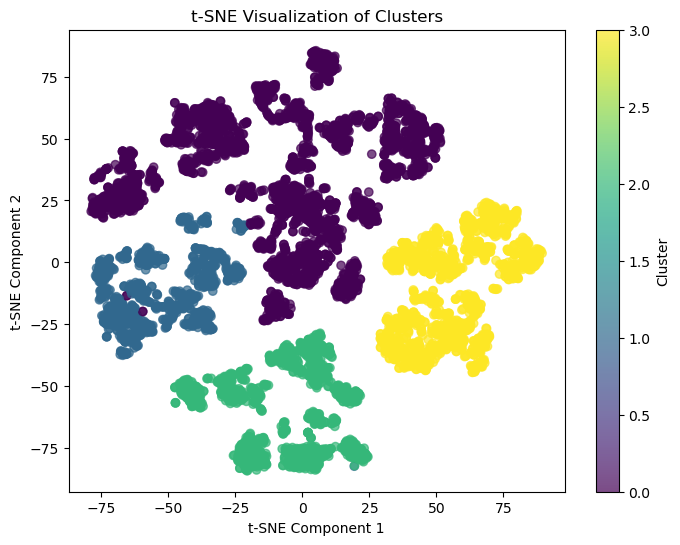

In [25]:
# Perform t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(workdata)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=workdata["Agg_Cluster"], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.colorbar(label="Cluster")
plt.show()

In [26]:
# Inverse transform data
agg_cluster_values = workdata["Agg_Cluster"].values 

workdata.drop(columns = ['KMeans_Cluster'], inplace = True)

workdata_original = pd.DataFrame(
    scaler.inverse_transform(workdata.drop(columns=["Agg_Cluster"])),
    columns=workdata.drop(columns=["Agg_Cluster"]).columns 
)

workdata_original["Agg_Cluster"] = agg_cluster_values

# Perform exp transformation on the log price, log Landsize, log BuildingArea and log Distance
workdata_original["Price(in thouands)"] = np.expm1(workdata_original["Log_Price"])/1000
workdata_original["BuildingArea"] = np.expm1(workdata_original["Log_BuildingArea"])
workdata_original["Landsize"] = np.expm1(workdata_original["Log_Landsize"])
workdata_original["Distance"] = np.expm1(workdata_original["Log_Distance"])

workdata_original.drop(columns = ['Log_Price', "Log_BuildingArea", "Log_Landsize", "Log_Distance"], inplace = True)

In [27]:
# Compute statistics for all clusters
cluster_summary = workdata_original.groupby("Agg_Cluster").agg(
    ['mean', 'median', 'std', 'min', 'max']
)

cluster_summary = cluster_summary.T
print("Cluster Summary Statistics:")
print(cluster_summary)

Cluster Summary Statistics:
Agg_Cluster                           0             1             2  \
Rooms              mean        3.254153      2.109181      2.870763   
                   median      3.000000      2.000000      3.000000   
                   std         0.476374      0.562036      0.618530   
                   min         2.000000      1.000000      1.000000   
                   max         5.000000      5.000000      4.000000   
Bedroom2           mean        3.240455      2.096774      2.833333   
                   median      3.000000      2.000000      3.000000   
                   std         0.480107      0.560627      0.614700   
                   min         2.000000      1.000000      1.000000   
                   max         5.000000      5.000000      5.000000   
Bathroom           mean        1.632177      1.175352      1.349576   
                   median      2.000000      1.000000      1.000000   
                   std         0.567797      0.40

In [28]:
# Merge "Type" and "Suburb" into workdata
houses = houses.reset_index(drop=True)
workdata_original[["Type","Suburb","Lattitude","Longtitude"]]  = houses[["Type","Suburb","Lattitude","Longtitude"]]

In [29]:
# Calculate the distribution of housing types in each Cluster
type_counts = workdata_original.groupby("Agg_Cluster")["Type"].value_counts().unstack()
print("Cluster Type Distribution:")
print(type_counts)

Cluster Type Distribution:
Type            h    t    u
Agg_Cluster                
0            2977  331  123
1             451  212  546
2            1394    7   15
3            1646   68    1


In [30]:
# Calculate the number of houses in each Cluster in different Suburbs
suburb_counts = workdata_original.groupby("Agg_Cluster")["Suburb"].value_counts().unstack()
print("Cluster Suburb Distribution:")
print(suburb_counts)

Cluster Suburb Distribution:
Suburb       Abbotsford  Aberfeldie  Airport West  Albanvale  Albert Park  \
Agg_Cluster                                                                 
0                  10.0         7.0          31.0        3.0          1.0   
1                   4.0         7.0          11.0        NaN          2.0   
2                  20.0         2.0           NaN        NaN         26.0   
3                   NaN        10.0           3.0        NaN          2.0   

Suburb       Albion  Alphington  Altona  Altona Meadows  Altona North  ...  \
Agg_Cluster                                                            ...   
0              19.0         1.0    18.0            12.0          28.0  ...   
1               7.0         4.0    12.0             NaN           4.0  ...   
2               NaN         2.0     NaN             NaN           NaN  ...   
3               NaN         9.0     3.0             NaN           NaN  ...   

Suburb       Whittlesea  Williams Landi

In [31]:
# Calculate the total number of houses in each Suburb
top_suburbs = workdata_original["Suburb"].value_counts().head(20).index

# Filter the data to keep only these popular Suburbs
filtered_suburb_counts = suburb_counts[top_suburbs]

# Count the number of houses in Suburb by Cluster
cluster_suburb_summary = workdata_original.groupby("Suburb")["Agg_Cluster"].value_counts().unstack()

# Only show the first 20 Suburbs
cluster_suburb_summary = cluster_suburb_summary.loc[top_suburbs]

print("Cluster Suburb Distribution (Top 20):")
print(cluster_suburb_summary)

Cluster Suburb Distribution (Top 20):
Agg_Cluster        0     1     2     3
Suburb                                
Reservoir       99.0  68.0   2.0  10.0
Bentleigh East  84.0  14.0   NaN  33.0
Brunswick        9.0  26.0  79.0  14.0
Coburg          21.0  29.0  54.0  17.0
Preston         43.0  36.0  22.0  15.0
Richmond        20.0  23.0  68.0   2.0
Glenroy         73.0  25.0   NaN   6.0
Yarraville      20.0  15.0  50.0  14.0
Pascoe Vale     52.0  31.0   6.0   9.0
Essendon        25.0  17.0  20.0  34.0
Balwyn North    23.0   3.0   6.0  63.0
Craigieburn     84.0   2.0   NaN   3.0
Northcote        2.0  12.0  63.0   9.0
Kew             12.0   8.0  22.0  44.0
Glen Iris       11.0  14.0  21.0  39.0
Ascot Vale      10.0  11.0  49.0  13.0
Brighton         8.0   9.0  20.0  46.0
Moonee Ponds    16.0   8.0  37.0  21.0
Newport         19.0  17.0  27.0  19.0
Camberwell      10.0  14.0  16.0  41.0


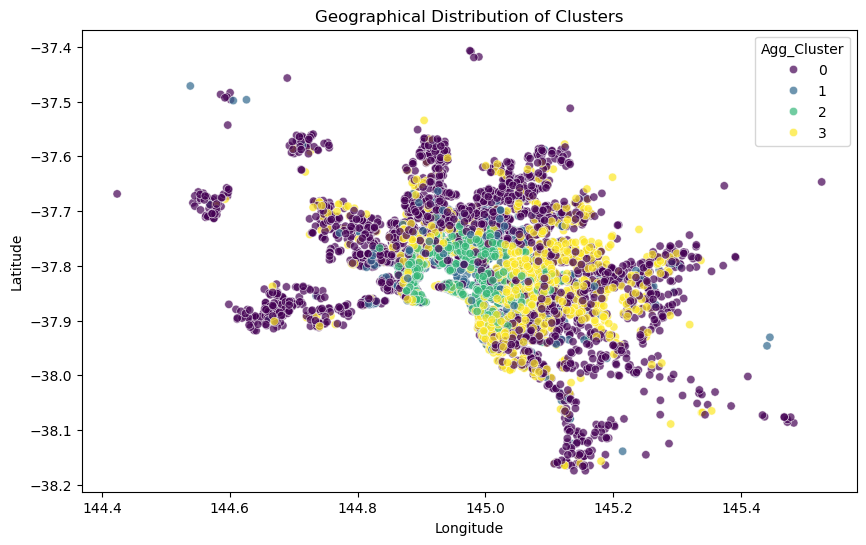

In [32]:
# Plot the geographical distribution of clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=workdata_original, x="Longtitude", y="Lattitude", hue="Agg_Cluster", palette="viridis", alpha=0.7)
plt.title("Geographical Distribution of Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Agg_Cluster")
plt.show()